In [99]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from pandas import DataFrame

#json
import json

<h3>Functions</h3>

In [100]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [101]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [102]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [103]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [104]:
def conf_mat_disp(confusion_matrix, disp_labels, t):
    
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                  display_labels = disp_labels)
        
        disp.plot(cmap = 'OrRd')
        disp.ax_.set_title(t)

In [105]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", title="AUC", fontsize=14, frameon=True)
    
    fig.tight_layout()
    plt.show()

In [106]:
def draw_precision_recall_curve(Y_test, Y_pred):
    
    fig, ax = plt.subplots()
    
    pr_ap = average_precision_score(Y_test, Y_pred, average = None)
    precision, recall, ap_thresholds = precision_recall_curve(Y_test, Y_pred)
    
    ax.plot(precision, recall, color = "#994D00", label='AP %0.4f' % (pr_ap))
    #ax.plot([0, 1], [no_skill, no_skill], 'r--', label='%0.4f' % no_skill) 
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision') 
    ax.tick_params(axis='both')
    ax.legend(loc="upper right", title="AP", frameon=True)
    ax.set_title("Model Precision-Recall curve")
    
    fig.tight_layout()
    plt.show()

In [107]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("Classification report")
    print(classification_report(y_test, y_pred_adj))
    print()
    print("Confusion matrix")
    print()
    cm = confusion_matrix(y_test, y_pred_adj)
    print(cm)
    print()
    
    conf_mat_disp(cm, clf.classes_, "Threshold test confusion matrix")

    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve (^ = current threshold)")
    plt.step(r, p, color='#994D00', alpha=0.5,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.5,
                     color='#994D00')
    plt.ylim([0, 1.0]);
    plt.xlim([0, 1.0]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^',
            markersize=15, mfc = "#800000", mec = "#800000")
    
    return y_pred_adj

<h3>Dataset</h3>

In [108]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [109]:
df_TEST = pd.read_csv("Numerical_Encoding_Test_HR_Employee_Attrition.csv")

In [110]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [112]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


In [113]:
df_TEST.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,27,1,3,15,2,1,0,1,2,5,...,14,4,2,1,2,2,2,374.542373,0.805503,2.4
1,30,1,2,16,4,1,0,3,3,5,...,13,1,3,2,3,8,0,271.457143,0.720871,2.2
2,56,0,1,2,4,4,0,3,2,1,...,11,3,1,2,2,13,3,290.550000,0.638272,3.2
3,41,1,2,18,5,4,0,4,1,7,...,17,3,0,4,3,3,0,241.516854,0.700861,3.0
4,42,0,2,1,3,4,0,3,1,4,...,22,1,1,6,3,5,3,281.736842,0.870820,3.0


In [114]:
df_TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       219 non-null    int64  
 1   Attrition                 219 non-null    int64  
 2   BusinessTravel            219 non-null    int64  
 3   DistanceFromHome          219 non-null    int64  
 4   Education                 219 non-null    int64  
 5   EnvironmentSatisfaction   219 non-null    int64  
 6   Gender                    219 non-null    int64  
 7   JobInvolvement            219 non-null    int64  
 8   JobLevel                  219 non-null    int64  
 9   JobRole                   219 non-null    int64  
 10  JobSatisfaction           219 non-null    int64  
 11  MonthlyIncome             219 non-null    int64  
 12  NumCompaniesWorked        219 non-null    int64  
 13  OverTime                  219 non-null    int64  
 14  PercentSal

In [115]:
df_TEST.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,36.447489,0.155251,2.123288,8.922374,3.022831,2.794521,0.319635,2.698630,2.077626,4.716895,...,15.264840,2.694064,0.844749,2.557078,2.762557,6.625571,3.949772,243.550215,0.435109,2.757991
std,8.379788,0.362974,0.531879,7.912851,1.051181,1.070354,0.467403,0.710697,1.144753,2.744843,...,3.717452,1.019314,0.842456,1.292243,0.702724,4.600208,3.227212,135.584686,0.327108,0.420646
min,22.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,33.715909,0.000000,1.400000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,125.273516,0.053626,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,230.823529,0.474904,2.800000
75%,41.500000,0.000000,2.000000,12.000000,4.000000,4.000000,1.000000,3.000000,2.000000,6.000000,...,18.000000,3.000000,1.000000,3.000000,3.000000,9.000000,7.000000,334.847370,0.750167,3.000000
max,58.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,15.000000,574.795455,0.913868,3.600000


<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [116]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [117]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
                        'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike'])], 
                       remainder = "drop")

<h4>Discretization of the training set</h4>

In [118]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [119]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,MonthlyIncome,MonthlyHours,PercentSalaryHike
0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,1.0,0.0,0.0,3.0,3.0
3,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [120]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [121]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [122]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,3.0,0,2,1.0,4,2,0,3,3,11,...,1.0,3,0,2,2,1.0,1.0,1.0,0.387172,2.6
1,1.0,0,2,0.0,1,2,0,3,5,8,...,0.0,3,1,3,3,0.0,1.0,1.0,0.411421,2.8
2,0.0,0,3,2.0,3,3,0,3,2,5,...,3.0,3,1,4,3,0.0,1.0,3.0,0.704402,3.2
3,1.0,0,2,0.0,4,2,0,3,1,4,...,0.0,2,0,1,3,0.0,1.0,2.0,0.841632,2.4
4,1.0,0,2,1.0,2,3,1,3,1,3,...,0.0,3,0,2,3,1.0,0.0,0.0,0.207947,3.2


<h4>Discretization of the test set</h4>

In [123]:
df_TEST.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,27,1,3,15,2,1,0,1,2,5,...,14,4,2,1,2,2,2,374.542373,0.805503,2.4
1,30,1,2,16,4,1,0,3,3,5,...,13,1,3,2,3,8,0,271.457143,0.720871,2.2
2,56,0,1,2,4,4,0,3,2,1,...,11,3,1,2,2,13,3,290.550000,0.638272,3.2
3,41,1,2,18,5,4,0,4,1,7,...,17,3,0,4,3,3,0,241.516854,0.700861,3.0
4,42,0,2,1,3,4,0,3,1,4,...,22,1,1,6,3,5,3,281.736842,0.870820,3.0


In [124]:
df_TEST_temp = pd.DataFrame(ct.fit_transform(df_TEST), columns = columns_to_discretize)
df_TEST_temp.head()

,Age,DistanceFromHome,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,MonthlyIncome,MonthlyHours,PercentSalaryHike
0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0
1,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0
3,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0
4,2.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0


In [125]:
df_TEST.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,27,1,3,15,2,1,0,1,2,5,...,14,4,2,1,2,2,2,374.542373,0.805503,2.4
1,30,1,2,16,4,1,0,3,3,5,...,13,1,3,2,3,8,0,271.457143,0.720871,2.2
2,56,0,1,2,4,4,0,3,2,1,...,11,3,1,2,2,13,3,290.550000,0.638272,3.2
3,41,1,2,18,5,4,0,4,1,7,...,17,3,0,4,3,3,0,241.516854,0.700861,3.0
4,42,0,2,1,3,4,0,3,1,4,...,22,1,1,6,3,5,3,281.736842,0.870820,3.0


In [126]:
for column in df_TEST_temp:
    if column in df_TEST:
        df_TEST[column] = df_TEST_temp[column]

In [127]:
df_TEST.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,0.0,1,3,2.0,2,1,0,1,2,5,...,0.0,4,2,1,2,0.0,0.0,2.0,0.805503,2.4
1,0.0,1,2,2.0,4,1,0,3,3,5,...,0.0,1,3,2,3,1.0,0.0,1.0,0.720871,2.2
2,3.0,0,1,0.0,4,4,0,3,2,1,...,0.0,3,1,2,2,2.0,0.0,2.0,0.638272,3.2
3,2.0,1,2,2.0,5,4,0,4,1,7,...,1.0,3,0,4,3,0.0,0.0,1.0,0.700861,3.0
4,2.0,0,2,0.0,3,4,0,3,1,4,...,3.0,1,1,6,3,0.0,0.0,2.0,0.870820,3.0


<h3>Divide into features and target</h3>

In [128]:
attributes = [col for col in df.columns if col != 'Attrition']

X_train = df[attributes].values
y_train = df['Attrition']

In [129]:
X_test = df_TEST[attributes].values
y_test = df_TEST['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

Results of the grid search

Best score ('roc_auc'): 0.6248684447562791
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


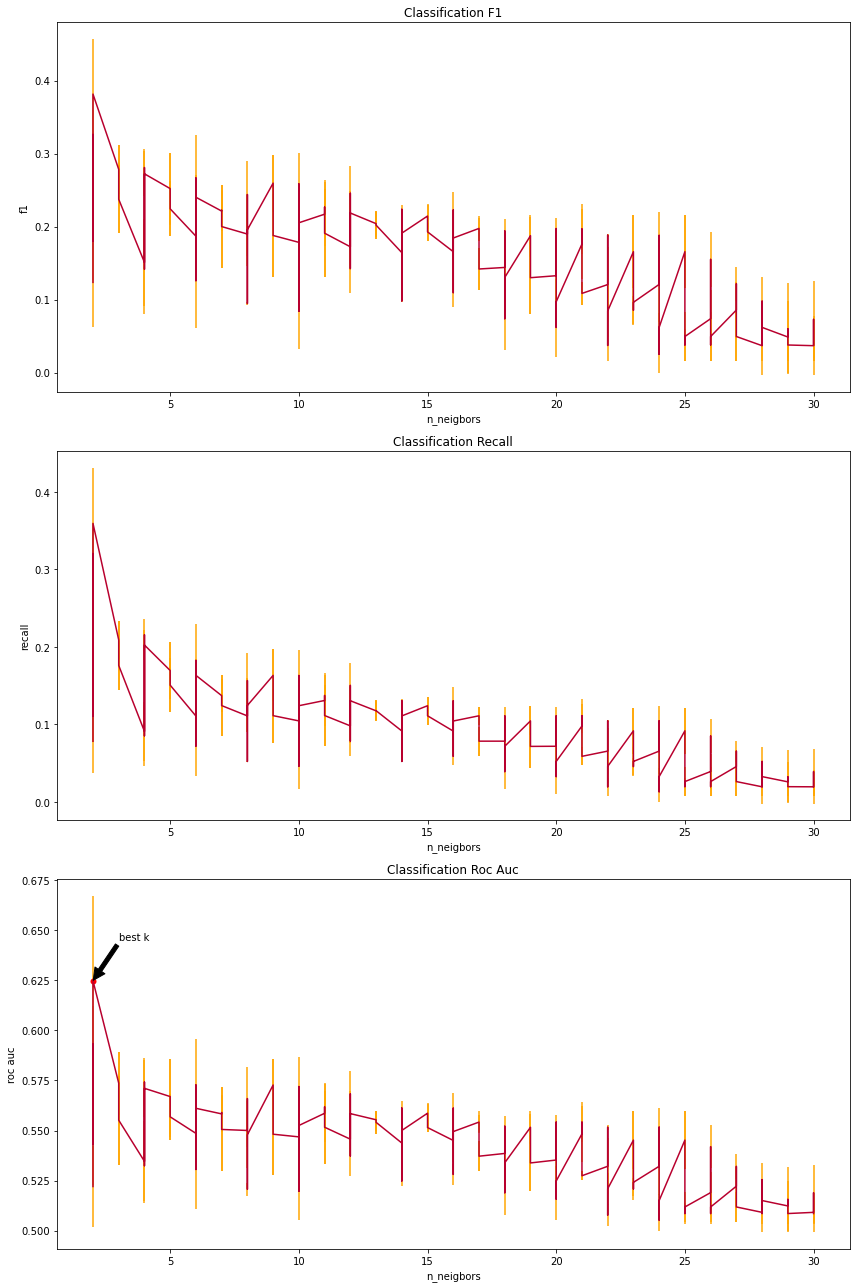



Permutation importances of the training set

OverTime                                           0.105114
Gender                                             0.072705
NumCompaniesWorked                                 0.021618
DistanceFromHome                                   0.007286
Age                                                0.007219
YearsAtCompany                                     0.005210
PercentSalaryHike                                  0.005207
StockOptionLevel                                   0.004778
MonthlyHours                                       0.003689
EnvironmentSatisfaction                            0.002193
TaxRate                                            0.001962
JobSatisfaction                                    0.000117
MonthlyIncome                                      0.000061
RelationshipSatisfaction                           0.000013
YearsInCurrentRole                                 0.000004
BusinessTravel                                     0.

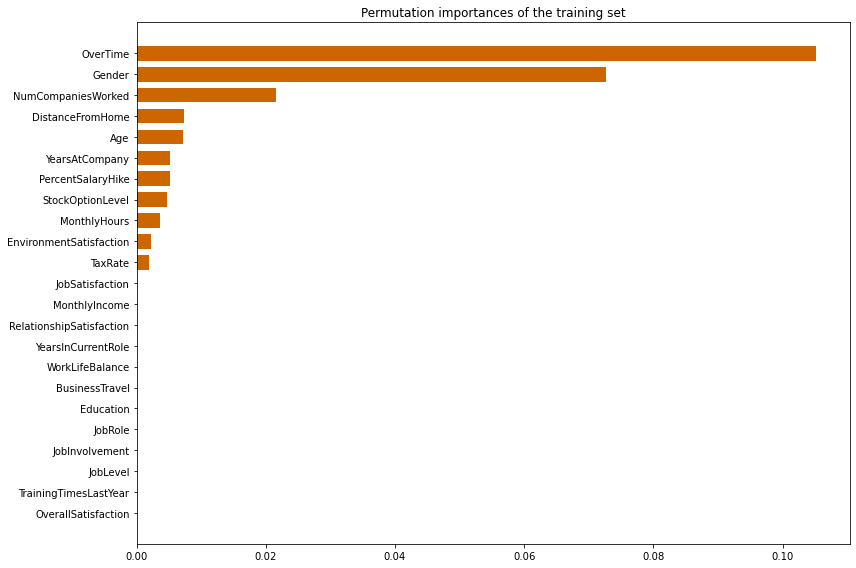



Predictions

Permutation importances of the test set

OverTime                                           0.071510
TaxRate                                            0.054618
JobInvolvement                                     0.051002
Age                                                0.041375
YearsAtCompany                                     0.037138
BusinessTravel                                     0.034833
JobSatisfaction                                    0.031892
YearsInCurrentRole                                 0.027448
JobRole                                            0.020874
EnvironmentSatisfaction                            0.018672
OverallSatisfaction                                0.014610
MonthlyIncome                                      0.013720
StockOptionLevel                                   0.012790
Gender                                             0.008776
TrainingTimesLastYear                              0.004364
DistanceFromHome                            

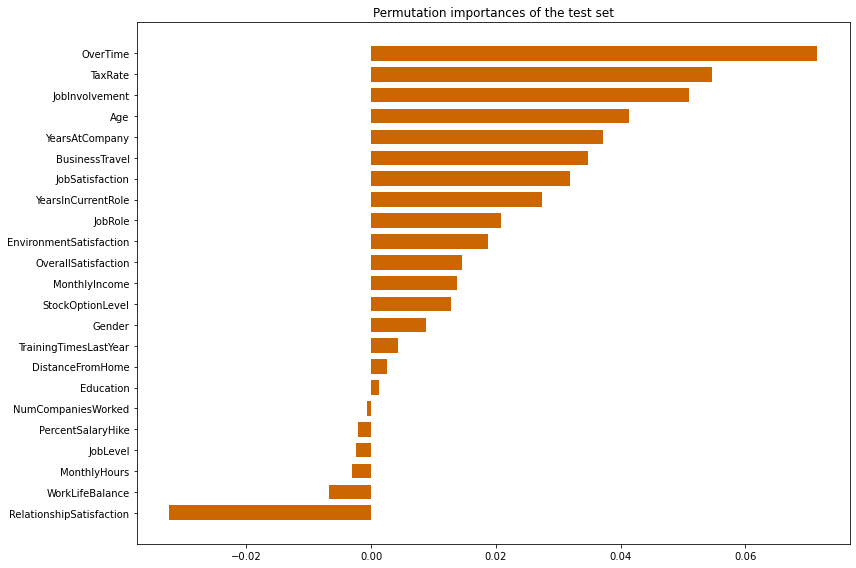



Confusion matrix


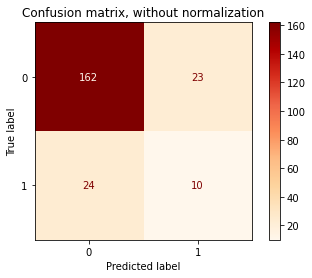

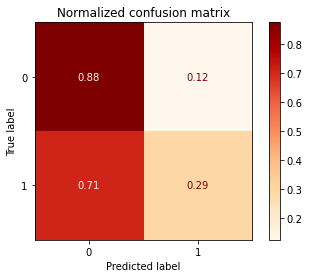


Classification report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       185
           1       0.30      0.29      0.30        34

    accuracy                           0.79       219
   macro avg       0.59      0.58      0.59       219
weighted avg       0.78      0.79      0.78       219


Metrics

Accuracy 0.7853881278538812
F1-score [0.87331536 0.29850746]
Precision [0.87096774 0.3030303 ]
Recall [0.87567568 0.29411765]
Roc_auc 0.5848966613672496


Roc curve



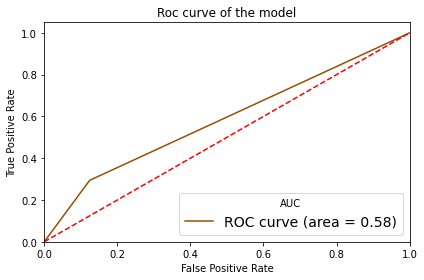

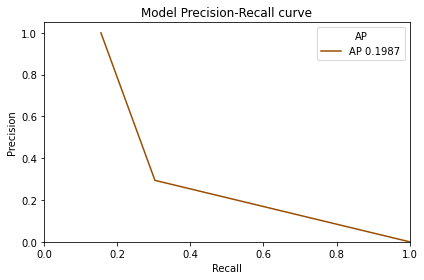

In [130]:
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}
    
    
#normalization
scaler = MaxAbsScaler()
    
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
    
#classifier
clf = KNeighborsClassifier()
    
#parameter list for the grid search
param_list = {'n_neighbors': k_range,
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
    
#grid search
grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
grid_search.fit(X_train_normalized, y_train)
    
#results of the grid search
print('\033[1m'"Results of the grid search"'\033[0m')
print()
print("Best score ('roc_auc'): %s" % grid_search.best_score_)
print("Best parameters: %s" % grid_search.best_params_)
print("Best estimator: %s" % grid_search.best_estimator_)
print()
print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
print()
    
#plot grid search results
print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
print()
print()
    
clf = grid_search.best_estimator_ #select the best estimator
    
#perform permutation importance of the training set
    
results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
#print results of permutation importance of the training set
title1 = "Permutation importances of the training set"
print('\033[1m'+title1+'\033[0m')
print()
    
train_sorted_feature_importances = results_permutation_importance(results1, attributes)
for t in train_sorted_feature_importances:
    print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
print()
plot_permutation_importance(results1, attributes, title1)
    
print()
print()
    

#Predictions
    
print('\033[1m'"Predictions"'\033[0m')
print()
    
y_pred = clf.predict(X_test_normalized)  #predict
    
    
# perform permutation importance of the test set
    
results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
#print results of permutation importance of the train
title2 = "Permutation importances of the test set"
print('\033[1m'+title2+'\033[0m')
print()
    
test_sorted_feature_importances = results_permutation_importance(results2, attributes)
for t in test_sorted_feature_importances:
    print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
print()
plot_permutation_importance(results2, attributes, title2)
    
print()
print()
    
    
#confusion matrix
print('\033[1m'"Confusion matrix"'\033[0m')
    
#plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
draw_confusion_matrix(clf, X_test_normalized, y_test)
        
print()
        
print('\033[1m'"Classification report"'\033[0m')
print(classification_report(y_test, y_pred))
        
print()
        
print('\033[1m'"Metrics"'\033[0m')
print()
        
print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
print()
print()
    
#plot the Roc Curve of the model
print('\033[1m'"Roc curve"'\033[0m')
print()
key = str(scaler).replace("()", "")
draw_roc_curve(y_test, y_pred, max_abs_dict, key)
print()

draw_precision_recall_curve(y_test, y_pred)


In [131]:
max_abs_dict

{'MaxAbsScaler': {'fpr': [0.0, 0.12432432432432433, 1.0],
  'tpr': [0.0, 0.29411764705882354, 1.0],
  'roc': 0.5848966613672496}}

In [132]:
temporal_info = {}

In [133]:
model_name = '24f numerical-encoded kmeans discretized'

In [134]:
temporal_info[model_name] = max_abs_dict['MaxAbsScaler']
temporal_info

{'24f numerical-encoded kmeans discretized': {'fpr': [0.0,
   0.12432432432432433,
   1.0],
  'tpr': [0.0, 0.29411764705882354, 1.0],
  'roc': 0.5848966613672496}}

In [135]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['kmeans']['test'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)